In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Config
sns.set(color_codes=True)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
from useful_functions import read_in_election_results, calc_marginal_within
from useful_functions import score_campaigns_difference, score_campaigns_uns,score_campaigns_mrp
from useful_functions import read_in_census

## Score constituencies

Read in election results and calculate various scoring metrics for the labour campaing in each constituency

- `base` : Simply the % share of votes Labour recieved in a constituency
- `diff` : Difference in number of votes between an election year and the comparisson year
- `uns` : Swing to/from labour in a constituency minus the national average swing
- `mrp` : Compare the Labour vote share with the YOUGOV MRP poll carried out 4 weeks before an election, only available for GE17 and GE19



In [3]:
election_results = read_in_election_results() 

In [4]:
#Pick year of interest, and one to compare with (neccesary for some of the scoring methods)
year = 19 # 2019 election
compare_year = 17 # normally the previous election year

In [5]:
base = pd.DataFrame(election_results[year]['lab_pc'],
                    index=election_results[year].index)

diff = score_campaigns_difference(election_results[year], 
                                  election_results[compare_year])

uns  = score_campaigns_uns(election_results[year], 
                           election_results[compare_year])

mrp  = score_campaigns_mrp(election_results[year])

In [6]:
# Compile all scoring metrics into one database `scores`
scores = pd.concat( [election_results[year]['Constituency'],
                     base['lab_pc'], diff['difference'],uns['difference'],mrp['difference'] ],
                    axis=1, verify_integrity=True, sort=True)
scores.columns = ['Constituency','base','diff','uns','mrp']
scores.sort_values('uns',ascending=False).head()

,Constituency,base,diff,uns,mrp
E14000589,Bradford West,0.762206,4292.0,0.194483,0.222206
E14000884,Portsmouth South,0.486410,4778.0,0.155008,0.066410
E14000958,Southport,0.389518,3140.0,0.142657,0.079518
E14000780,Leeds North West,0.486395,3555.0,0.124321,-0.003605
E14000887,Putney,0.451384,3655.0,0.122549,0.111384


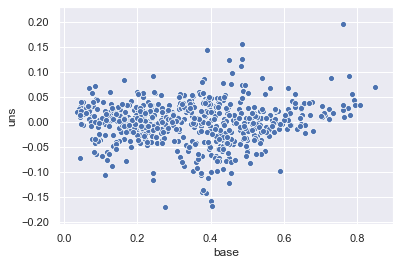

In [7]:
ax = sns.scatterplot(scores['base'],scores['uns'])

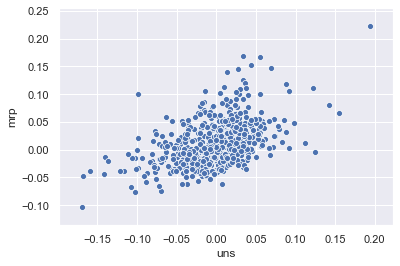

In [8]:
sns.scatterplot(scores['uns'],scores['mrp'])

In [9]:
# seats that labour won by, or were within a certain percentage of winning
marginals = calc_marginal_within(0.10,election_results[compare_year])

## Select demographic data to compare constituencies

In [10]:
census = read_in_census()
# only want rows we have election data for
census = census.loc[election_results[year].index]

In [11]:
features = ['c11PopulationDensity',
            'c11HouseOwned',
            'c11CarsNone',
            'c11EthnicityWhite',
            'c11Unemployed',
            'c11Retired',
            'c11FulltimeStudent',
            'c11Age65to74',
            'c11DeprivedNone']

In [12]:
demographic_data = census[features]

In [13]:
# only want constituencies we have complete data for
demographic_data = demographic_data.dropna()
# Speaker seats have incomplete voting data
speaker_seats = census.index[census['constituency_name'].isin(['Chorley', 'Buckingham'])]
demographic_data = demographic_data.drop(speaker_seats)

loss = set(census.index) - set(demographic_data.index)
print('Loss =',len(loss))

Loss = 79


In [14]:
# Make some lookup containers
constits_id = demographic_data.index
constits_name = list(census.loc[constits_id]['constituency_name'])
id_to_name = {id_:name for id_,name in zip(constits_id, constits_name)}
name_to_id = {name:id_ for id_,name in zip(constits_id, constits_name)}
id_to_index = {onsid:i for i,onsid in enumerate(constits_id)}
name_to_index = {name:i for i,name in enumerate(constits_name)}

scores = scores.loc[constits_id] # only interested in these constits now

We can now see the spread of constituencies based on their demographics.

The graph below shows contituencies close to similar constituencies. Do not read too much into the axes. Points are coloured by their labour swing relative to the national labour swing.

In [48]:
#name_to_id

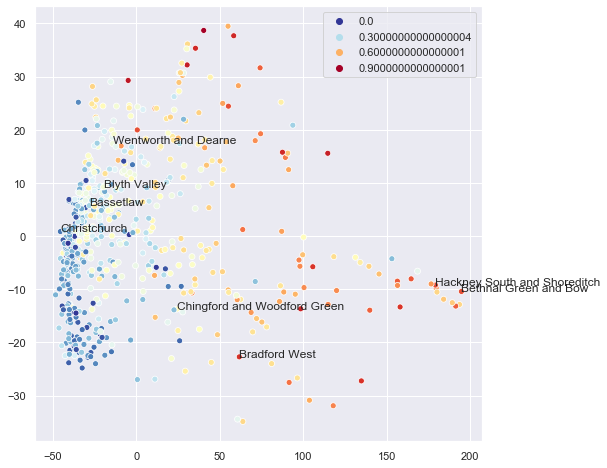

In [52]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)

X_transformed = embedding.fit_transform(demographic_data)
x = pd.Series(X_transformed[:,0])
y = pd.Series(X_transformed[:,1])

plt.figure(figsize=(8,8))
#hues = list(scores['uns']-0.079)
hues = list(scores['base'])
ax = sns.scatterplot(x=x,y=y,hue=hues, palette='RdYlBu_r')

for constit in ['Bethnal Green and Bow', 'Hackney South and Shoreditch','Christchurch',
                'Bradford West','Bassetlaw','Wentworth and Dearne','Blyth Valley','Chingford and Woodford Green']:
    ax.text(x[name_to_index[constit]], 
            y[name_to_index[constit]],
            constit)

In [53]:
#from sklearn.decomposition import PCA
#from sklearn import preprocessing
#pca = PCA(n_components=2)
#X_transformed = pca.fit_transform(preprocessing.scale(demographic_data))
#x_pca = pd.Series(X_transformed[:,0])
#y_pca = pd.Series(X_transformed[:,1])

#plt.figure(figsize=(8,8))
#hues = list(scores['uns']-0.079)
#hues = list(scores['base'])
#ax = sns.scatterplot(x=x_pca,y=y_pca,hue=hues, palette='RdYlBu_r')

#pd.DataFrame({f:c for f,c in zip(features,pca.components_[0])})
#for f,c in zip(features,pca.components_[1]):
#    print(f,c)

In [54]:
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances

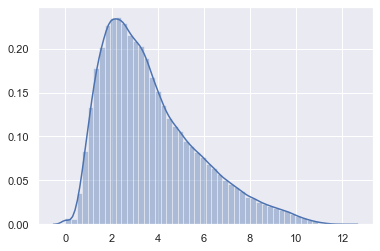

In [55]:
# Show distribution of distances between constituencies
X_scaled = preprocessing.scale(demographic_data)
dist_matrix = pairwise_distances(X_scaled)
sns.distplot(np.ndarray.flatten(dist_matrix))

In [56]:
scores['Constituency'].iloc[np.where(dist_matrix == np.max(dist_matrix))[0]]

ons_id
E14000638           Christchurch
E14000555    Bethnal Green & Bow
Name: Constituency, dtype: object

## Calculate confidence that a local campaign was succesful

All constituencies are compared with each other.

We calculate the 'distance' between each constituency according their demographics. Similar constituencies, based on the features chosen above, will have a small distance between them.

We then calculate the relative score between each campaign.

This relative score is divided by the distance between each constituency. Our confidence in a constituencies campaing is the sum of this value between all other constituencies.

If constituency A scored much better than constituency B, and they are very similar in demographics, A will recieve a positive contribution and B will recieve a negative one.

In [57]:
def distance(X, cutoff=None):
    return pairwise_distances(X)

def distance_cutoff(X, cutoff):
    dist_matrix = distance(X)
    mask = dist_matrix > cutoff
    dist_matrix[mask] = 0
    return dist_matrix

def distance_rescale(X, exponent=math.e):
    dist_matrix = distance(X)
    return exponent**dist_matrix
    
def calc_significance_matrix(demographic_data, constit_score, 
                             dist_func=distance, **kwargs):
    X_scaled      = preprocessing.scale(demographic_data)
    dist_matrix   = dist_func(X_scaled, **kwargs)
    constit_score = preprocessing.scale(constit_score)
    score_matrix  = constit_score[:,np.newaxis] - constit_score
    significance  = np.zeros(score_matrix.shape) # need to initialise all to zero
    np.divide( score_matrix, dist_matrix, where=dist_matrix!=0,
             out=significance)
    return significance
    
def calc_campaign_conf(demographic_data, constit_score, 
                             dist_func=distance, **kwargs):
    #assert np.all( demographic_data.index == constit_score.index )
    significance = calc_significance_matrix(demographic_data, constit_score, dist_func, **kwargs)
    return pd.Series(np.sum(significance,1),index=constits_id)

In [58]:
cutoff = 1
results = pd.DataFrame({
                        'constituency': constits_name,
                        'uns': calc_campaign_conf(demographic_data, scores['uns']),
                        'uns_cut': calc_campaign_conf(demographic_data, scores['uns'],distance_cutoff, cutoff=cutoff),
                        'uns_rescale': calc_campaign_conf(demographic_data, scores['uns'],distance_rescale, exponent=10)
                       }, index = constits_id)
results.head()

,constituency,uns,uns_cut,uns_rescale
ons_id,,,,
E14000754,Houghton and Sunderland South,-463.240381,-8.754477,-8.873928
E14000831,Newcastle Upon Tyne Central,17.886596,0.000000,0.013542
E14000832,Newcastle Upon Tyne East,5.107099,0.000000,-0.099379
E14000833,Newcastle Upon Tyne North,-86.876725,2.787251,-0.537045
E14000982,Sunderland Central,-207.788400,0.000000,-1.390275


In [70]:
#results[results['constituency']=='Chingford and Woodford Green']

The following plot shows constituencies that according to this metric did well (red) or badly (blue). If a constituency is not similar to many others, the score is close to zero because we don't have much to compare to.

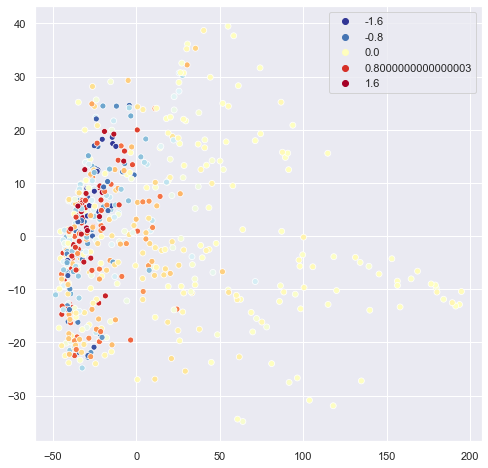

In [59]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=x,y=y,hue=np.tanh(np.array(results['uns_rescale'])/10), palette='RdYlBu_r')

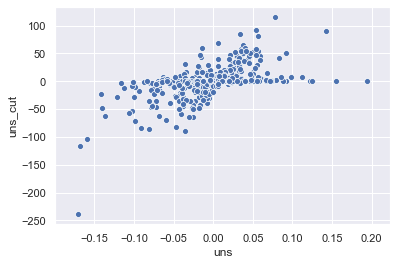

In [60]:
sns.scatterplot(x=scores['uns'],y=results['uns_cut'])

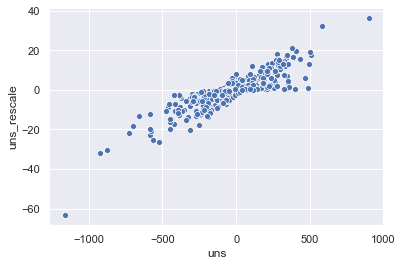

In [61]:
sns.scatterplot(x=results['uns'],y=results['uns_rescale'])

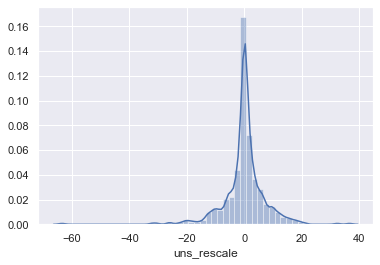

In [71]:
sns.distplot(results['uns_rescale'])

In [62]:
results.sort_values('uns_rescale',ascending=False).head(10)

,constituency,uns,uns_cut,uns_rescale
ons_id,,,,
E14000958,Southport,903.505010,89.475386,36.502673
W07000078,Vale Of Glamorgan,582.989396,115.757242,32.312117
E14000961,St Austell and Newquay,381.678226,91.580859,20.963145
E14000743,Hereford and South Herefordshire,409.267913,54.935082,19.701710
W07000063,Montgomeryshire,503.844069,42.238572,19.011768
E14000704,Folkestone and Hythe,276.722648,84.251337,18.237829
E14000614,Calder Valley,346.683503,50.834569,17.700726
E14000762,Isle Of Wight,511.987872,51.232496,17.432359
E14000682,East Worthing and Shoreham,385.633274,28.338278,16.812946


In [63]:
def list_similar(constit, N=5):
    index = id_to_index[constit]
    dists = dist_matrix[index]
    close_indexes = np.argsort(dists)
    
    df = pd.DataFrame({'name': id_to_name[constit],
                       'distance': 0},
                      index = [constit])

    for i in range(1,N+1):
        j = close_indexes[i]
        df = df.append( pd.DataFrame({'name': constits_name[j],
                                     'distance': dists[j]},
                                     index = [constits_id[j]])
                      )
    return df

In [64]:
def list_significances(constit, significance_matrix, scores, N=5):
    index = id_to_index[constit]
    dists = dist_matrix[index]
    significances = significance_matrix[index]
    most_signif = np.argsort(-abs(significances))

    df = pd.DataFrame({'name': id_to_name[constit],
                       'significance': 0,
                       'distance': 0,
                       'score': scores.loc[constit]},
                      index = [constit])
    
    for i in range(N):
        j = most_signif[i]
        df = df.append( pd.DataFrame({'name': constits_name[j],
                                      'significance': significances[j],
                                     'distance': dists[j],
                                     'score': scores[constits_id[j]]},
                                     index = [constits_id[j]])
                      )
    return df

### Investigate a constituency's score

Define a constituency of interest `coi` in the cell below to see where it's score comes from.

In [65]:
# coi needs to a be an ONSID
#coi = name_to_id['Vale Of Glamorgan']
coi = name_to_id['Chingford and Woodford Green']

In [66]:
significance_matrix = calc_significance_matrix(demographic_data, 
                                               scores['uns'], 
                                               distance_rescale, 
                                               exponent=10)
list_significances(coi, significance_matrix, scores['uns'],10)


,name,significance,distance,score
E14000634,Chingford and Woodford Green,0.000000,0.000000,0.098182
E14000621,Carshalton and Wallington,0.273458,0.835257,0.018432
E14000599,Bristol East,0.266964,0.921562,0.003209
E14000558,Bexleyheath and Crayford,0.234851,0.898574,0.018941
E14000861,Northampton North,0.178870,1.014040,0.019448
E14000692,"Enfield, Southgate",0.164373,0.865352,0.046805
E14000650,Coventry North West,0.146236,1.286576,-0.022381
E14000548,Batley and Spen,0.145689,1.374954,-0.049038
E14000979,Stretford and Urmston,0.134566,1.165341,0.014263
E14000711,Gillingham and Rainham,0.118393,1.257432,0.006909


In [72]:
list_similar(coi)

,name,distance
E14000634,Chingford and Woodford Green,0.000000
E14000621,Carshalton and Wallington,0.835257
E14000692,"Enfield, Southgate",0.865352
E14000558,Bexleyheath and Crayford,0.898574
E14000599,Bristol East,0.921562
E14000861,Northampton North,1.014040


In [73]:
# use these onsids to view in the separate notebook: show_constits.ipynb
list_similar(coi).index

Index(['E14000634', 'E14000621', 'E14000692', 'E14000558', 'E14000599',
       'E14000861'],
      dtype='object')

This cell is meant to plot constituencies by demographics, then draw lines between constits that contribute to its result.

## Sensetivity Analysis

In [ ]:
def sub_sample_features(features=features,subsample_size=1):
    from itertools import combinations
    return combinations(features,subsample_size)
    #return np.random.choice(features,subsample,replace=False)

def noise(array, factor=0.1):
    mean = np.mean(array, axis=0)
    std = np.std(array, axis=0)
    rng = np.random.RandomState()
    noise = rng.normal(mean, std * factor, size=array.shape)
    return array + noise

from sklearn.metrics import r2_score

df = results.copy()
print('Drop feature, r2_score')
for i,exclude in enumerate(sub_sample_features(subsample_size=1)):
    df[i] = calc_campaign_conf(demographic_data.drop(columns=list(exclude)), 
                               scores['uns'], distance_rescale, exponent=10)
    print(exclude,'\t', r2_score(df['uns_rescale'],df[i]))

print('\n 10% noise to demographics')
df = results.copy()
for i in range(5):    
    df[i] = calc_campaign_conf(noise(demographic_data), scores['uns'], 
                               distance_rescale, exponent=10)
    print(r2_score(df['uns_rescale'],df[i]))
    
print('\n 10% noise to score')
df = results.copy()
for i in range(5):    
    df[i] = calc_campaign_conf(demographic_data, noise(scores['uns']), 
                               distance_rescale, exponent=10)
    print(r2_score(df['uns_rescale'],df[i]))

In [ ]:
coi = name_to_id['Vale Of Glamorgan']
significance_matrix = calc_significance_matrix(demographic_data, scores['uns'])
centre_i = id_to_index[coi]
contributions = significance_matrix[centre_i]

# coi = constits of interest
cois = [coi]
linexs = []
lineys = []
values = []

N = 10
for i in np.flip(np.argsort(np.abs(contributions))[-N:]):
    onsid = demographic_data.index[i]
    cois += [onsid]
    values += [contributions[i]]
    #print(contributions[i],id_to_name[onsid,election_results[year]])

from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, MDS, TSNE
embedding = Isomap(n_components=2)

X = demographic_data#[mask]
X_transformed = embedding.fit_transform(X)
x = pd.Series(X_transformed[:,0])
y = pd.Series(X_transformed[:,1])

for c in cois:
    linexs += [ [x[centre_i],x[id_to_index[c]] ] ]
    lineys += [ [y[centre_i],y[id_to_index[c]] ] ]
    
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x,y=y)
#values = preprocessing.scale(values)
for linex,liney,value in zip(linexs,lineys,values):
    plt.plot(linex,liney,linewidth=value, color='blue')

val = pd.Series([id_to_name[i] for i in X.index])
a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)

for c in cois:
    ax.text(x[id_to_index[c]], y[id_to_index[c]], id_to_name[c])
    #ax.text(point['x']+.001, point['y'], str(point['val']))

In [36]:
swing = pd.concat([ scores['uns'],demographic_data],axis=1, verify_integrity=True, sort=True)

In [37]:
swing.head()

,uns,c11PopulationDensity,c11HouseOwned,c11CarsNone,c11EthnicityWhite,c11Unemployed,c11Retired,c11FulltimeStudent,c11Age65to74,c11DeprivedNone
ons_id,,,,,,,,,,
E14000530,-0.001805,19.614660,65.426048,15.825351,85.533381,3.637000,10.325348,6.690939,7.028348,47.943774
E14000531,-0.015795,17.483482,75.594167,19.131244,93.128849,4.553607,18.657412,6.162344,11.750721,39.975178
E14000532,0.058887,18.709288,74.080473,16.001903,90.433891,3.039963,14.139160,6.895702,8.780321,54.415484
E14000533,-0.037339,7.051190,72.468212,21.039414,98.388767,4.261173,16.989668,5.294369,10.090689,40.566761
E14000534,0.010121,1.507467,75.970149,10.346654,97.748466,2.468100,18.684355,5.549608,12.340259,51.468464


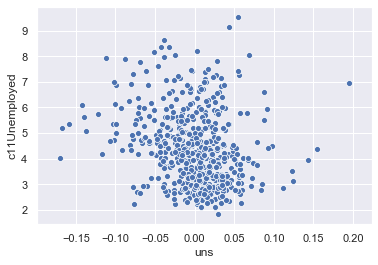

In [43]:
sns.scatterplot(x=swing['uns'],y=swing['c11Unemployed'])

0.011721245032373458


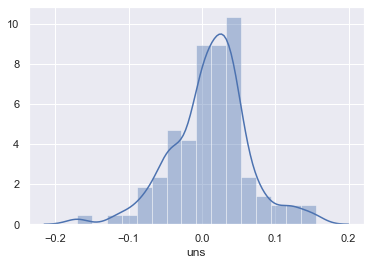

In [77]:
print(np.mean(scores['uns'].loc[marginals]))
sns.distplot(scores['uns'].loc[marginals])